In [ ]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

| | |
|----------|-------------|
| Author(s)   | Lei Pan |
| Last updated | 11/08/2023 |

# Talk to Codebase via Codey, Matching Engine and RAG

Codey models are text-to-code models from Google AI, trained on a massive code related dataset. You can generate code related responses for different scenarios such as writing functions, unit tests, debugging, explaining code etc. Here is [the overview](https://cloud.google.com/vertex-ai/docs/generative-ai/code/code-models-overview) of all the Codey APIs.

In this notebook, we will show you how to chat with your codebase through RAG (Codey is generator and codebase embeddings in Vertex matching engine is retriever)

If you are not familiar with RAG, you can read [this paper](https://arxiv.org/pdf/2005.11401.pdf)

- Step 1: Create matching engine index and endpoint for codebase retrieval
- Step 2: Add codebase embeddings to matching engine - vector store
- Step 3: Retrieval based question/answering chain setup



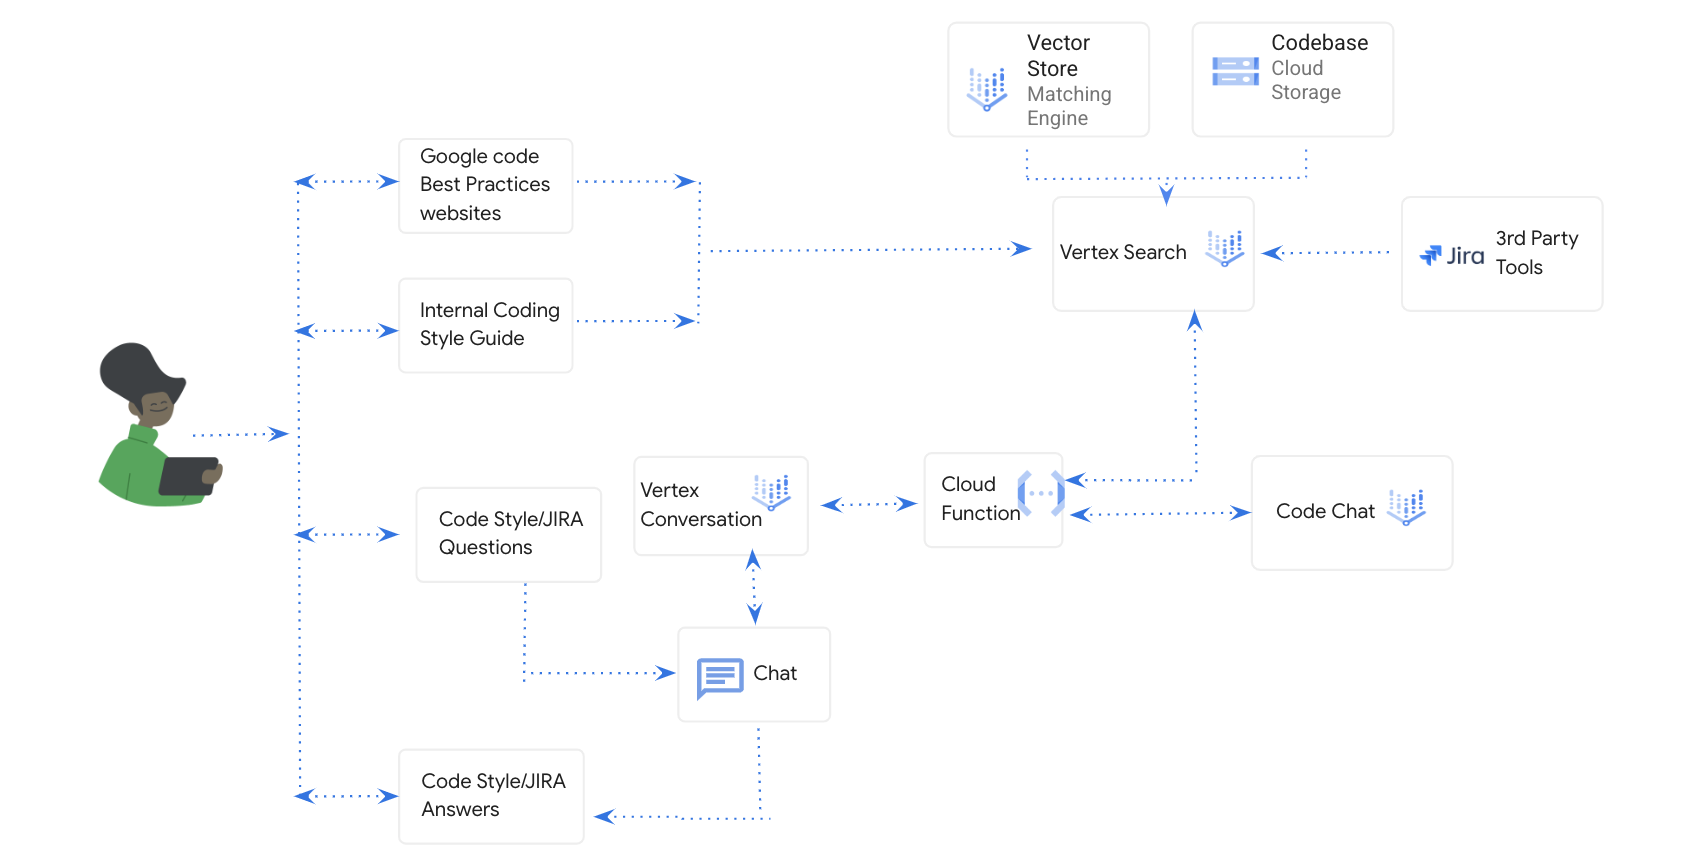

## Prep Work



### Install Vertex AI SDK, other packages and their dependencies

Install the following packages required to execute this notebook.

*To use the newly installed packages in this Jupyter runtime, you must restart the runtime. You can do this by running the cell below, which will restart the current kernel.

In [ ]:
# Install Vertex AI LLM SDK
! pip install --user --upgrade google-cloud-aiplatform==1.35.0 langchain==0.0.323

# Dependencies required
! sudo apt -y -qq install tesseract-ocr libtesseract-dev
! sudo apt-get -y -qq install poppler-utils
! pip install --user unstructured==0.7.5 pdf2image==1.16.3 pytesseract==0.3.10 pdfminer.six==20221105

# For Matching Engine integration dependencies (default embeddings)
! pip install --user tensorflow_hub==0.13.0 tensorflow_text==2.12.1

<div class="alert alert-block alert-warning">
<b>⚠️ Before proceeding, please wait for the kernel to finish restarting ⚠️</b>
</div>

### Authenticating your notebook environment
If you are using Colab, you will need to authenticate yourself first. The next cell will check if you are currently using Colab, and will start the authentication process.

In [ ]:
import sys

if "google.colab" in sys.modules:
    from google.colab import auth as google_auth
    google_auth.authenticate_user()

### Download custom Python modules and utilities

The cell below will download some helper functions needed for using [Vertex AI Matching Engine](https://cloud.google.com/vertex-ai/docs/matching-engine/overview) in this notebook. These helper functions were created to keep this notebook more tidy and concise, and you can also [view them directly on Github](https://github.com/GoogleCloudPlatform/generative-ai/tree/main/language/use-cases/document-qa/utils).

In [ ]:
import os
import urllib.request

if not os.path.exists("utils"):
    os.makedirs("utils")

url_prefix = "https://raw.githubusercontent.com/GoogleCloudPlatform/generative-ai/main/language/use-cases/document-qa/utils"
files = ["__init__.py", "matching_engine.py", "matching_engine_utils.py"]

for fname in files:
    urllib.request.urlretrieve(f"{url_prefix}/{fname}", filename=f"utils/{fname}")

### Import libraries

In [ ]:
import json
import textwrap

# Utils
import time
import uuid
from typing import List

import numpy as np
import vertexai

# Vertex AI
from google.cloud import aiplatform

print(f"Vertex AI SDK version: {aiplatform.__version__}")

# LangChain
import langchain

print(f"LangChain version: {langchain.__version__}")

from langchain.chains import RetrievalQA
from langchain.document_loaders import GCSDirectoryLoader
from langchain.embeddings import VertexAIEmbeddings
from langchain.llms import VertexAI
from langchain.prompts import PromptTemplate
from langchain.text_splitter import RecursiveCharacterTextSplitter
from pydantic import BaseModel

# Import custom Matching Engine packages
from utils.matching_engine import MatchingEngine
from utils.matching_engine_utils import MatchingEngineUtils

Vertex AI SDK version: 1.35.0
LangChain version: 0.0.323


Please set PROJECT_ID and REGION below with your project id and location for Vertex AI. This should be the project in which you enabled Vertex AI

In [ ]:
PROJECT_ID = "<your project id>"
REGION = "<location>"

# Initialize Vertex AI SDK
vertexai.init(project=PROJECT_ID, location=REGION)

Next you will define some utility functions that you will use for the Vertex AI Embeddings API

In [ ]:
# Utility functions for Embeddings API with rate limiting
def rate_limit(max_per_minute):
    period = 60 / max_per_minute
    print("Waiting")
    while True:
        before = time.time()
        yield
        after = time.time()
        elapsed = after - before
        sleep_time = max(0, period - elapsed)
        if sleep_time > 0:
            print(".", end="")
            time.sleep(sleep_time)


class CustomVertexAIEmbeddings(VertexAIEmbeddings, BaseModel):
    requests_per_minute: int
    num_instances_per_batch: int

    # Overriding embed_documents method
    def embed_documents(self, texts: List[str]):
        limiter = rate_limit(self.requests_per_minute)
        results = []
        docs = list(texts)

        while docs:
            # Working in batches because the API accepts maximum 5
            # documents per request to get embeddings
            head, docs = (
                docs[: self.num_instances_per_batch],
                docs[self.num_instances_per_batch :],
            )
            chunk = self.client.get_embeddings(head)
            results.extend(chunk)
            next(limiter)

        return [r.values for r in results]

### Initialize LangChain Models

You initialize LangChain Models with the pre-trained text, chat and embeddings generation model called code generation model

In [ ]:
# Text model instance integrated with langChain
llm = VertexAI(
    model_name="code-bison@001",
    max_output_tokens=1024,
    temperature=0.2
)

# Embeddings API integrated with langChain
EMBEDDING_QPM = 100
EMBEDDING_NUM_BATCH = 5
embeddings = CustomVertexAIEmbeddings(
    requests_per_minute=EMBEDDING_QPM,
    num_instances_per_batch=EMBEDDING_NUM_BATCH,
)

---

## Step 1: Create Matching Engine Index and Endpoint for Codebase Retrieval




- Configure parameters to create Matching Engine index
    - `ME_REGION`: Region where Matching Engine Index and Index Endpoint are deployed
    - `ME_INDEX_NAME`: Matching Engine index display name
    - `ME_EMBEDDING_DIR`: Cloud Storage path to allow inserting, updating or deleting the contents of the Index
    - `ME_DIMENSIONS`: The number of dimensions of the input vectors. Vertex AI Embedding API generates 768 dimensional vector embeddings.

In [ ]:
ME_REGION = "<lcoation>"
ME_INDEX_NAME = f"{PROJECT_ID}-me-index"
ME_EMBEDDING_DIR = f"{PROJECT_ID}-me-bucket"
ME_DIMENSIONS = 768  # when using Vertex PaLM Embedding

Make a Google Cloud Storage bucket for your Matching Engine index

In [ ]:
! set -x && gsutil mb -p $PROJECT_ID -l us-central1 gs://$ME_EMBEDDING_DIR

+ gsutil mb -p certain-haiku-391918 -l us-central1 gs://certain-haiku-391918-me-bucket
Creating gs://certain-haiku-391918-me-bucket/...
ServiceException: 409 A Cloud Storage bucket named 'certain-haiku-391918-me-bucket' already exists. Try another name. Bucket names must be globally unique across all Google Cloud projects, including those outside of your organization.


- Create a dummy embeddings file to initialize when creating the index

In [ ]:
# dummy embedding
init_embedding = {"id": str(uuid.uuid4()), "embedding": list(np.zeros(ME_DIMENSIONS))}

# dump embedding to a local file
with open("embeddings_0.json", "w") as f:
    json.dump(init_embedding, f)

# write embedding to Cloud Storage
! set -x && gsutil cp embeddings_0.json gs://{ME_EMBEDDING_DIR}/init_index/embeddings_0.json

+ gsutil cp embeddings_0.json gs://certain-haiku-391918-me-bucket/init_index/embeddings_0.json
Copying file://embeddings_0.json [Content-Type=application/json]...
/ [1 files][  3.8 KiB/  3.8 KiB]                                                
Operation completed over 1 objects/3.8 KiB.                                      


### Create Index


In [ ]:
mengine = MatchingEngineUtils(PROJECT_ID, ME_REGION, ME_INDEX_NAME)

In [ ]:
index = mengine.create_index(
    embedding_gcs_uri=f"gs://{ME_EMBEDDING_DIR}/init_index",
    dimensions=ME_DIMENSIONS,
    index_update_method="streaming",
    index_algorithm="tree-ah",
)
if index:
    print(index.name)

...............................................projects/656421903914/locations/us-central1/indexes/8850844303224733696


### Deploy Index to Endpoint


In [ ]:
index_endpoint = mengine.deploy_index()
if index_endpoint:
    print(f"Index endpoint resource name: {index_endpoint.name}")
    print(
        f"Index endpoint public domain name: {index_endpoint.public_endpoint_domain_name}"
    )
    print("Deployed indexes on the index endpoint:")
    for d in index_endpoint.deployed_indexes:
        print(f"    {d.id}")

...................Index endpoint resource name: projects/656421903914/locations/us-central1/indexEndpoints/8413432189416374272
Index endpoint public domain name: 
Deployed indexes on the index endpoint:


---

## Step 2: Add Codebase Embeddings to Matching Engine - Vector Store

This step ingests and parse codebase, split them, generate embeddings and add the embeddings to the vector store. The codebase corpus used as dataset is a sample of Google published research papers across different domains - large models, traffic simulation, productivity etc.

Load codebase and add codebase metadata such as file name, to be retrieved later when citing the references.

* You need to upload the codebase to the GCS bucket you created above. You can follow the instruction below.
* You can download and unzip this zip file - bank_of_anthos_codebase.zip from [github](https://github.com/GoogleCloudPlatform/applied-ai-engineering-samples/tree/main/genai-on-vertex-ai/developer_productivity_with_genai/utilities) to get the sample codebase we use in this notebook. Then upload it to the GCS bucket.

In [ ]:
from typing import Callable, List, Optional

from langchain.docstore.document import Document
from langchain.document_loaders.base import BaseLoader
from langchain.document_loaders.gcs_file import GCSFileLoader
from langchain.utilities.vertexai import get_client_info


class GCSDirectoryLoaderNew(BaseLoader):
    """Load from GCS directory."""

    def __init__(
        self,
        project_name: str,
        bucket: str,
        prefix: str = "",
        loader_func: Optional[Callable[[str], BaseLoader]] = None,
    ):
        """Initialize with bucket and key name.

        Args:
            project_name: The ID of the project for the GCS bucket.
            bucket: The name of the GCS bucket.
            prefix: The prefix of the GCS bucket.
            loader_func: A loader function that instantiates a loader based on a
                file_path argument. If nothing is provided, the  GCSFileLoader
                would use its default loader.
        """
        self.project_name = project_name
        self.bucket = bucket
        self.prefix = prefix
        self._loader_func = loader_func

    def load(self) -> List[Document]:
        """Load documents."""
        try:
            from google.cloud import storage
        except ImportError:
            raise ImportError(
                "Could not import google-cloud-storage python package. "
                "Please install it with `pip install google-cloud-storage`."
            )
        client = storage.Client(
            project=self.project_name,
            client_info=get_client_info(module="google-cloud-storage"),
        )
        docs = []
        for blob in client.list_blobs(self.bucket, prefix=self.prefix):
            # we shall just skip directories since GCSFileLoader creates
            # intermediate directories on the fly
            if blob.name.endswith("/"):
                continue
            loader = GCSFileLoader(
                self.project_name, self.bucket, blob.name, loader_func=self._loader_func
            )
            print(f"Loading {blob.name}")
            docs.extend(loader.load())
        return docs

You should set GCS_BUCKET_DOCS with the folder name in the GCS bucket. This is the folder where you store codebase

In [ ]:
GCS_BUCKET_DOCS = "<bucket name>"
print(f"Processing codebase from {GCS_BUCKET_DOCS}")
loader = GCSDirectoryLoaderNew(
    project_name=PROJECT_ID, bucket=GCS_BUCKET_DOCS,
)
documents = loader.load()

# Add document name and source to the metadata
for document in documents:
    doc_md = document.metadata
    document_name = doc_md["source"].split("/")[-1]
    # derive doc source from Document loader
    doc_source_prefix = "/".join(GCS_BUCKET_DOCS.split("/")[:3])
    doc_source_suffix = "/".join(doc_md["source"].split("/")[4:-1])
    source = f"{doc_source_prefix}/{doc_source_suffix}"
    document.metadata = {"source": source, "document_name": document_name}
    print(f"{document_name}: {source}")

print(f"# of documents loaded (pre-chunking) = {len(documents)}")

Verify document metadata

In [ ]:
documents[10].metadata

{'source': 'certain-haiku-391918-documents/docs',
 'document_name': 'troubleshooting.md'}

### Chunk code repo

Split the code to smaller chunks. When splitting the document, ensure a few chunks can fit within the context length of LLM.

In [ ]:
# split the documents into chunks
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=2000, #1000
    chunk_overlap=200 #50
    ) #    separators=["\n\n", "\n", ".", "!", "?", ",", " ", ""],

doc_splits = text_splitter.split_documents(documents)

# Add chunk number to metadata
for idx, split in enumerate(doc_splits):
    split.metadata["chunk"] = idx

print(f"# of documents = {len(doc_splits)}")

# of documents = 631


In [ ]:
doc_splits[10].metadata #a sanity check

{'source': 'certain-haiku-391918-documents/',
 'document_name': 'README.md',
 'chunk': 10}

### Configure Matching Engine as Vector Store

Get Matching Engine Index id and Endpoint id

In [ ]:
ME_INDEX_ID, ME_INDEX_ENDPOINT_ID = mengine.get_index_and_endpoint()
print(f"ME_INDEX_ID={ME_INDEX_ID}")
print(f"ME_INDEX_ENDPOINT_ID={ME_INDEX_ENDPOINT_ID}")

ME_INDEX_ID=projects/656421903914/locations/us-central1/indexes/8850844303224733696
ME_INDEX_ENDPOINT_ID=projects/656421903914/locations/us-central1/indexEndpoints/8413432189416374272


Initialize Matching Engine vector store with text embeddings model

In [ ]:
# initialize vector store
me = MatchingEngine.from_components(
    project_id=PROJECT_ID,
    region=ME_REGION,
    gcs_bucket_name=f"gs://{ME_EMBEDDING_DIR}".split("/")[2],
    embedding=embeddings,
    index_id=ME_INDEX_ID,
    endpoint_id=ME_INDEX_ENDPOINT_ID,
)

In [ ]:
# Store docs as embeddings in Matching Engine index
# It may take a while since API is rate limited
texts = [doc.page_content for doc in doc_splits]
metadatas = [
    [
        {"namespace": "source", "allow_list": [doc.metadata["source"]]},
        {"namespace": "document_name", "allow_list": [doc.metadata["document_name"]]},
        {"namespace": "chunk", "allow_list": [str(doc.metadata["chunk"])]},
    ]
    for doc in doc_splits
]

In [ ]:
doc_ids = me.add_texts(texts=texts, metadatas=metadatas)


Waiting
..............................................................................................................................

In [ ]:
# Test whether search from vector store is working
me.similarity_search("what does LICENSE file say?", k=2)

Waiting


[Document(page_content='/** * Copyright 2021 Google LLC * * Licensed under the Apache License, Version 2.0 (the "License"); * you may not use this file except in compliance with the License. * You may obtain a copy of the License at * *      http://www.apache.org/licenses/LICENSE-2.0 * * Unless required by applicable law or agreed to in writing, software * distributed under the License is distributed on an "AS IS" BASIS, * WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. * See the License for the specific language governing permissions and * limitations under the License. */\n\noutput "cluster_location" {\n\nvalue = module.gke.location\n\n}\n\noutput "cluster_name" {\n\nvalue = module.gke.name\n\n}', metadata={'source': 'certain-haiku-391918-documents/iac/tf-anthos-gke', 'document_name': 'outputs.tf', 'chunk': '191', 'score': 0.7146704196929932}),
 Document(page_content='# Copyright 2021 Google LLC # # Licensed under the Apache License, Version 2.0 (the "License

In [ ]:
me.similarity_search("What is NFC?", k=2, search_distance=0.4)


## Step 3: Retrieval based Question/Answering Chain


### Configure Question/Answering Chain with Vector Store using Text

Define Matching Engine Vector Store as retriever that takes in a query and returns a list of relevant documents. The retriever implementation supports configuring number of documents to fetch and filtering by search distance as a threshold value parameter.

In [ ]:
# Create chain to answer questions
NUMBER_OF_RESULTS = 3
SEARCH_DISTANCE_THRESHOLD = 0.6

# Expose index to the retriever
retriever = me.as_retriever(
    search_type="similarity",
    search_kwargs={
        "k": NUMBER_OF_RESULTS,
        "search_distance": SEARCH_DISTANCE_THRESHOLD,
    },
)

Customize the default retrieval prompt template

In [ ]:
template = """SYSTEM: You are an intelligent assistant helping the users with their questions and you will use the provided context to answer user questions with detailed explanations.

Question: {question}

Strictly Use ONLY the following pieces of context to answer the question at the end. Think step-by-step and then answer.

Do not try to make up an answer:

=============
{context}
=============

Question: {question}
Helpful Answer:"""

Configure RetrievalQA chain

In [ ]:
# Uses LLM to synthesize results from the search index.
# Use Vertex PaLM Text API for LLM
qa = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=retriever,
    return_source_documents=True,
    verbose=True,
    chain_type_kwargs={
        "prompt": PromptTemplate(
            template=template,
            input_variables=["context", "question"],
        ),
    },
)

Enable verbose logging for debugging and troubleshooting the chains which includes the complete prompt to the LLM

In [ ]:
# Enable for troubleshooting
qa.combine_documents_chain.verbose = True
qa.combine_documents_chain.llm_chain.verbose = True
qa.combine_documents_chain.llm_chain.llm.verbose = True

Utility function to format the result

In [ ]:
def formatter(result):
    print(f"Query: {result['query']}")
    print("." * 80)
    if "source_documents" in result.keys():
        for idx, ref in enumerate(result["source_documents"]):
            print("-" * 80)
            print(f"REFERENCE #{idx}")
            print("-" * 80)
            if "score" in ref.metadata:
                print(f"Matching Score: {ref.metadata['score']}")
            if "source" in ref.metadata:
                print(f"Document Source: {ref.metadata['source']}")
            if "document_name" in ref.metadata:
                print(f"Document Name: {ref.metadata['document_name']}")
            print("." * 80)
            print(f"Content: \n{wrap(ref.page_content)}")
    print("." * 80)
    print(f"Response: {wrap(result['result'])}")
    print("." * 80)


def wrap(s):
    return "\n".join(textwrap.wrap(s, width=120, break_long_words=False))


def ask(query, qa=qa, k=NUMBER_OF_RESULTS, search_distance=SEARCH_DISTANCE_THRESHOLD):
    qa.retriever.search_kwargs["search_distance"] = search_distance
    qa.retriever.search_kwargs["k"] = k
    result = qa({"query": query})
    return formatter(result)

### Run QA chain on sample questions



In [ ]:
ask("what does LICENSE file say?")



> Entering new RetrievalQA chain...
Waiting


> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
SYSTEM: You are an intelligent assistant helping the users with their questions and you will use the provided context to answer user questions with detailed explanations.

Question: what does LICENSE file say?

Strictly Use ONLY the following pieces of context to answer the question at the end. Think step-by-step and then answer.

Do not try to make up an answer:

/** * Copyright 2021 Google LLC * * Licensed under the Apache License, Version 2.0 (the "License"); * you may not use this file except in compliance with the License. * You may obtain a copy of the License at * *      http://www.apache.org/licenses/LICENSE-2.0 * * Unless required by applicable law or agreed to in writing, software * distributed under the License is distributed on an "AS IS" BASIS, * WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. * See

In [ ]:
ask("what are the pom dependencies in this project?")



> Entering new RetrievalQA chain...
Waiting


> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
SYSTEM: You are an intelligent assistant helping the users with their questions and you will use the provided context to answer user questions with detailed explanations.

Question: what are the pom dependencies in this project?

Strictly Use ONLY the following pieces of context to answer the question at the end. Think step-by-step and then answer.

Do not try to make up an answer:

4.0.0

ledgermonolith

jar

Ledger Monolith

Ledger Monolith

1.0

org.springframework.boot

spring



boot



starter



parent

3.1.4

17

4.2.1

./checkstyle.xml

2022.0.4

com.google.cloud

spring



cloud



gcp



dependencies

4.8.1

pom

import

org.springframework.cloud

spring



cloud



dependencies

${spring



cloud.version}

pom

import

com.google.cloud

libraries



bom

26.24.0

pom

import

org.springframework.boot

spring



boot



start

In [ ]:
ask("how does CI/CD pipeline that powers Bank of Anthos work?")



> Entering new RetrievalQA chain...
Waiting


> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
SYSTEM: You are an intelligent assistant helping the users with their questions and you will use the provided context to answer user questions with detailed explanations.

Question: how does CI/CD pipeline that powers Bank of Anthos work?

Strictly Use ONLY the following pieces of context to answer the question at the end. Think step-by-step and then answer.

Do not try to make up an answer:

CI/CD pipeline

This document introduces the CI/CD pipeline that powers Bank of Anthos' production instance (hosted here: https://bank-of-anthos.xyz/) as well as how you can get started deploying it in your own Google Cloud project (with your own domain name).

Cloud Build and

Cloud Deploy, with the help of

Terraform,

Skaffold, and

Kustomize. The end result is multiple environments in a multi-stage pipeline (development, staging, production) wh

---

## Clean Up

Please delete Matching Index and Index Endpoint after running your experiments to avoid incurring additional charges. Please note that you will be charged as long as the endpoint is running.



<div class="alert alert-block alert-warning">
<b>⚠️ NOTE: Enabling `CLEANUP_RESOURCES` flag deletes Matching Engine Index, Index Endpoint and Cloud Storage bucket. Please run it with caution.</b>
</div>

In [ ]:
CLEANUP_RESOURCES = True

In [ ]:
ME_INDEX_ID, ME_INDEX_ENDPOINT_ID = mengine.get_index_and_endpoint()
print(f"ME_INDEX_ID={ME_INDEX_ID}")
print(f"ME_INDEX_ENDPOINT_ID={ME_INDEX_ENDPOINT_ID}")

ME_INDEX_ID=projects/656421903914/locations/us-central1/indexes/7488505415945158656
ME_INDEX_ENDPOINT_ID=projects/656421903914/locations/us-central1/indexEndpoints/380136354094252032


- Undeploy indexes and Delete index endpoint

In [ ]:
if CLEANUP_RESOURCES and "mengine" in globals():
    print(
        f"Undeploying all indexes and deleting the index endpoint {ME_INDEX_ENDPOINT_ID}"
    )
    mengine.delete_index_endpoint()

Undeploying all indexes and deleting the index endpoint projects/656421903914/locations/us-central1/indexEndpoints/380136354094252032


- Delete index

In [ ]:
if CLEANUP_RESOURCES and "mengine" in globals():
    print(f"Deleting the index {ME_INDEX_ID}")
    mengine.delete_index()

Deleting the index projects/656421903914/locations/us-central1/indexes/7488505415945158656


- Delete contents from the Cloud Storage bucket

In [ ]:
if CLEANUP_RESOURCES and "ME_EMBEDDING_DIR" in globals():
    print(f"Deleting contents from the Cloud Storage bucket {ME_EMBEDDING_DIR}")
    ME_EMBEDDING_BUCKET = "/".join(ME_EMBEDDING_DIR.split("/")[:3])

    shell_output = ! gsutil du -ash gs://$ME_EMBEDDING_BUCKET
    print(shell_output)
    print(
        f"Size of the bucket {ME_EMBEDDING_BUCKET} before deleting = {' '.join(shell_output[0].split()[:2])}"
    )

    # uncomment below line to delete contents of the bucket
    # ! gsutil -m rm -r gs://$ME_EMBEDDING_BUCKET

Deleting contents from the Cloud Storage bucket certain-haiku-391918-me-bucket
['3.81 KiB     gs://certain-haiku-391918-me-bucket']
Size of the bucket certain-haiku-391918-me-bucket before deleting = 3.81 KiB
